# Engine C: Causal Inference Engine (Contextual Anomaly Detection)

This notebook builds the third and final engine of the Cognitive Shield framework. Instead of just finding correlations, this engine aims to understand the **context** and plausible **causes** behind user actions. It acts as our reasoning layer to reduce false positives.

**Objective:** To train a model that predicts fraud by focusing on features that represent the "why" behind a transaction. Is there a valid reason for this high-value transfer? Or does it lack a normal causal trigger?

**Process:**
1.  **Load Data:** Load `events.csv` and `users.csv`.
2.  **Causal Feature Engineering:** This is the core step. We will create features that proxy real-world causes:
    - User's historical spending habits (baseline).
    - Proximity to events like "salary day".
    - Contextual features like time of day and device novelty.
3.  **Train a Gradient Boosting Model:** We'll use LightGBM, a fast and powerful model, to learn the complex, non-linear interactions between these features.
4.  **Evaluate and Score:** Generate a `CausalAnomalyScore` and visualize its effectiveness.
5.  **Explainability with SHAP:** Use SHAP (SHapley Additive exPlanations) to interpret individual model predictions, providing human-readable reasons for alerts.

In [3]:
pip install seaborn shap

Defaulting to user installation because normal site-packages is not writeable
  Using cached shap-0.48.0-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.48.0-cp312-cp312-win_amd64.whl (545 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import shap
import os
import matplotlib.pyplot as plt

# --- Configuration ---
EVENTS_FILE = '../data/events.csv'
USERS_FILE = '../data/users.csv'
MODEL_SAVE_PATH = '../src/models/engine_c_lgbm.pkl'
DEVICE = 'cpu' # LightGBM runs on CPU

print(f"--- Engine C Setup ---")
print(f"Loading event data from: {EVENTS_FILE}")

# Load data
df = pd.read_csv(EVENTS_FILE, parse_dates=['timestamp'])
users_df = pd.read_csv(USERS_FILE, parse_dates=['customer_since'])

print("\nData loaded successfully.")

--- Engine C Setup ---
Loading event data from: ../data/events.csv

Data loaded successfully.


## 2. Causal Feature Engineering

This is where we imbue our model with domain knowledge. We're creating features that a human fraud analyst would look for to determine if a transaction is legitimate or suspicious.

In [5]:
print("--- Starting Feature Engineering ---")

# 1. User's Historical Baseline Features (Pre-computation)
# For each user, calculate their normal behavior BEFORE the evaluation period.
train_period_end = df['timestamp'].max() - pd.Timedelta(days=30)
df_historical = df[df['timestamp'] <= train_period_end]

user_stats = df_historical.groupby('user_id')['amount'].agg(['mean', 'std', 'count']).reset_index()
user_stats.columns = ['user_id', 'avg_amount', 'std_amount', 'tx_count']
user_stats = user_stats.fillna(0)

# Merge these stats back into the main dataframe
df = df.merge(user_stats, on='user_id', how='left').fillna(0)

# 2. Transaction-level Causal Features
# We will focus only on events with a monetary amount for this model
df_tx = df[df['amount'] > 0].copy()

# Amount deviation from user's norm
df_tx['amount_deviation'] = (df_tx['amount'] - df_tx['avg_amount']) / (df_tx['std_amount'] + 1e-6) # Add epsilon to avoid division by zero

# Time-based features
df_tx['hour_of_day'] = df_tx['timestamp'].dt.hour
df_tx['day_of_week'] = df_tx['timestamp'].dt.dayofweek # Monday=0, Sunday=6
df_tx['is_weekend'] = (df_tx['day_of_week'] >= 5).astype(int)
df_tx['is_business_hours'] = ((df_tx['hour_of_day'] >= 9) & (df_tx['hour_of_day'] <= 18)).astype(int)

# Time since last event for the user
df_tx = df_tx.sort_values('timestamp')
df_tx['time_since_last_event_sec'] = df_tx.groupby('user_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# Device novelty
# Get first time a user used a device
first_use = df.groupby(['user_id', 'device_id'])['timestamp'].min().reset_index()
first_use.rename(columns={'timestamp': 'first_use_timestamp'}, inplace=True)
df_tx = df_tx.merge(first_use, on=['user_id', 'device_id'], how='left')
df_tx['is_new_device_for_user'] = (df_tx['timestamp'] == df_tx['first_use_timestamp']).astype(int)


# Session features
session_stats = df.groupby('session_id')['event_id'].count().to_frame('events_in_session')
df_tx = df_tx.merge(session_stats, on='session_id', how='left').fillna(1)


# "Salary Day" Proxy: Did a large credit happen recently? (A simplified approach)
# A full implementation would check for specific salary-like transactions.
# Here, we just check for any large incoming transfer as a proxy.
df_tx['is_after_large_credit'] = 0 # Placeholder for a more complex feature

print("Feature engineering complete.")
print("Sample of features created:")
display(df_tx[['user_id', 'amount', 'amount_deviation', 'is_new_device_for_user', 'time_since_last_event_sec', 'is_fraud']].tail())

--- Starting Feature Engineering ---
Feature engineering complete.
Sample of features created:


,user_id,amount,amount_deviation,is_new_device_for_user,time_since_last_event_sec,is_fraud
166875,usr_638f033acfc9,223.93,-0.513806,0,142.0,False
166876,usr_b99daf5448d7,438.32,-0.285735,0,73.0,False
166877,usr_957aed839905,184798.35,1.467090,0,161.0,False
166878,usr_b99daf5448d7,122.07,-0.541254,0,59.0,False
166879,usr_957aed839905,9122.02,-0.333198,0,169.0,False


## 3. Model Training with LightGBM

We'll use a Light Gradient Boosting Machine (LightGBM) model. It's highly efficient, scalable, and excellent at capturing complex interactions between features, which is perfect for our causal feature set. We will train the model to predict the `is_fraud` label.

In [6]:
# Define features and target
features = [
    'amount', 'avg_amount', 'std_amount', 'tx_count', 
    'amount_deviation', 'hour_of_day', 'day_of_week', 
    'is_weekend', 'is_business_hours', 'time_since_last_event_sec',
    'is_new_device_for_user', 'events_in_session'
]
target = 'is_fraud'

X = df_tx[features]
y = df_tx[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Train the LightGBM model
print("\n--- Starting Model Training ---")
lgbm = lgb.LGBMClassifier(objective='binary', 
                          metric='auc', 
                          n_estimators=1000, 
                          learning_rate=0.05,
                          num_leaves=31,
                          random_state=42,
                          colsample_bytree=0.8,
                          subsample=0.8,
                          reg_alpha=0.1,
                          reg_lambda=0.1)

lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='auc',
         callbacks=[lgb.early_stopping(100, verbose=False)])

print("Model training complete.")

# Save the model
import pickle
with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(lgbm, f)
print(f"Model saved to {MODEL_SAVE_PATH}")

Training data shape: (116816, 12)
Testing data shape: (50064, 12)

--- Starting Model Training ---
[LightGBM] [Info] Number of positive: 210, number of negative: 116606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1405
[LightGBM] [Info] Number of data points in the train set: 116816, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001798 -> initscore=-6.319448
[LightGBM] [Info] Start training from score -6.319448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

## 4. Scoring and Evaluation

We use our trained model to predict the probability of fraud on the test set. This probability becomes our `CausalAnomalyScore`. As with the other engines, we expect to see a clear separation in the score distributions between legitimate and fraudulent transactions.

In [8]:
import seaborn as sns

--- Evaluating Model Performance ---
Model AUC on Test Set: 1.0000


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


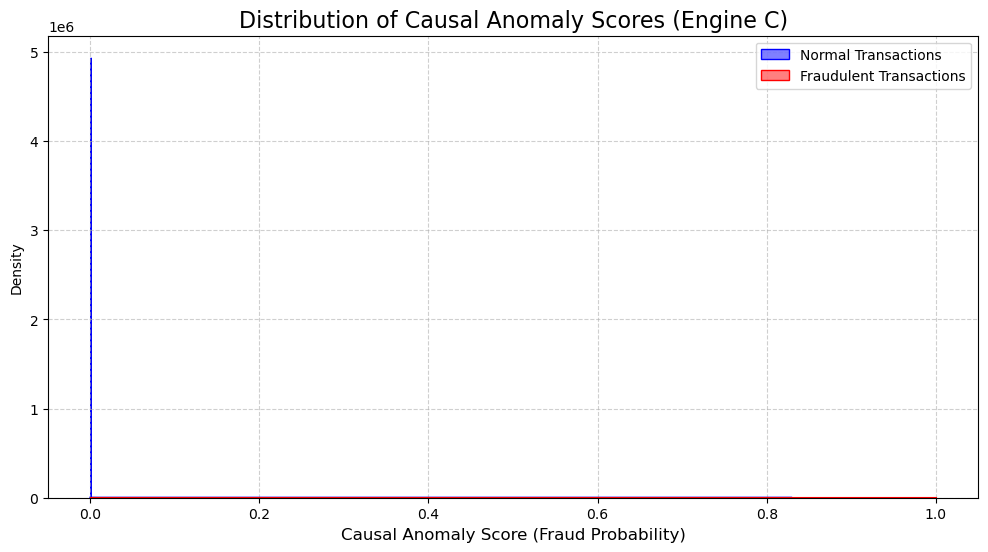

In [9]:
print("--- Evaluating Model Performance ---")

# Predict probabilities on the test set
test_probs = lgbm.predict_proba(X_test)[:, 1]

# Causal Anomaly Score is the predicted probability of fraud
causal_scores = test_probs

# Evaluate
auc_score = roc_auc_score(y_test, causal_scores)
print(f"Model AUC on Test Set: {auc_score:.4f}")

# Separate scores for visualization
normal_scores = causal_scores[y_test == 0]
fraud_scores = causal_scores[y_test == 1]

# Visualize the distributions
plt.figure(figsize=(12, 6))
sns.histplot(normal_scores, color="blue", label='Normal Transactions', kde=True, stat="density", element="step")
sns.histplot(fraud_scores, color="red", label='Fraudulent Transactions', kde=True, stat="density", element="step")
plt.title('Distribution of Causal Anomaly Scores (Engine C)', fontsize=16)
plt.xlabel('Causal Anomaly Score (Fraud Probability)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 5. Explainability with SHAP

This is the final and most powerful piece of Engine C. We use the SHAP library to "explain" the model's decisions for individual transactions.

The force plot below shows which features pushed the model's output from the "base value" (the average prediction) to the final prediction.
- **Features in red** pushed the score HIGHER (towards fraud).
- **Features in blue** pushed the score LOWER (towards legitimate).

This provides a clear, human-readable reason for each alert, directly addressing the core business problem of explainability.


--- Generating SHAP Explanations ---


C:\Users\Sidhant\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP returned single-class output.

Explaining a High-Risk Fraudulent Transaction (index: 882):


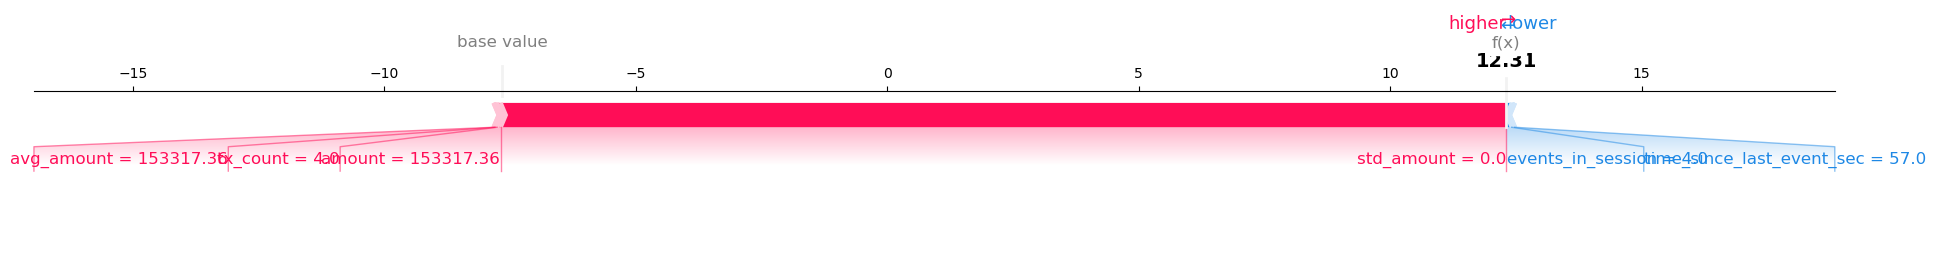


Explaining a Low-Risk Legitimate Transaction (index: 0):


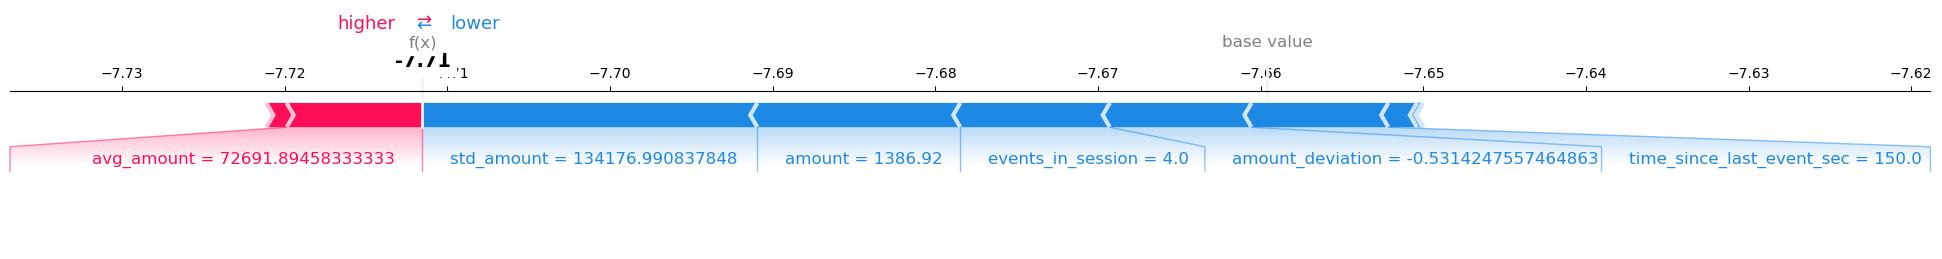


Overall Feature Importance (SHAP Summary Plot):


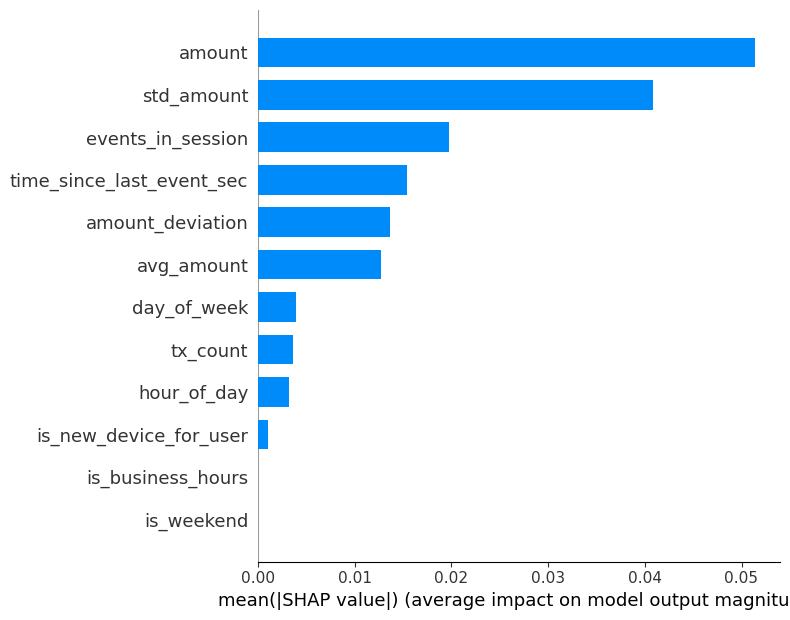

In [11]:
print("\n--- Generating SHAP Explanations ---")

# Create a SHAP explainer
explainer = shap.TreeExplainer(lgbm)
shap_values_output = explainer.shap_values(X_test)

# --- ROBUST FIX STARTS HERE ---
# Check if SHAP returned values for one class or two
if isinstance(shap_values_output, list) and len(shap_values_output) > 1:
    # It's a multi-class output, so we select the values for the positive class (class 1)
    shap_values_for_plot = shap_values_output[1]
    base_value_for_plot = explainer.expected_value[1]
    print("SHAP returned multi-class output. Using values for Class 1 (Fraud).")
else:
    # It's a single-class output, so we use the values directly
    shap_values_for_plot = shap_values_output
    base_value_for_plot = explainer.expected_value
    print("SHAP returned single-class output.")
# --- ROBUST FIX ENDS HERE ---


# Find a correctly identified fraud case
fraud_indices = np.where((y_test == 1) & (causal_scores > 0.8))[0]
if len(fraud_indices) > 0:
    fraud_idx = fraud_indices[0]
    print(f"\nExplaining a High-Risk Fraudulent Transaction (index: {fraud_idx}):")
    
    # Create the SHAP force plot using our robustly selected values
    shap.force_plot(base_value_for_plot, shap_values_for_plot[fraud_idx,:], X_test.iloc[fraud_idx,:], matplotlib=True, show=False)
    plt.tight_layout()
    display(plt.gcf()) # Display the current figure
    plt.close() # Close the plot to prevent it from displaying twice
else:
    print("No high-confidence fraud cases found in the test set to explain.")


# Find a correctly identified legitimate case
legit_indices = np.where((y_test == 0) & (causal_scores < 0.1))[0]
if len(legit_indices) > 0:
    legit_idx = legit_indices[0]
    print(f"\nExplaining a Low-Risk Legitimate Transaction (index: {legit_idx}):")
    
    # Create the SHAP force plot using our robustly selected values
    shap.force_plot(base_value_for_plot, shap_values_for_plot[legit_idx,:], X_test.iloc[legit_idx,:], matplotlib=True, show=False)
    plt.tight_layout()
    display(plt.gcf())
    plt.close()
else:
    print("No high-confidence legitimate cases found in the test set to explain.")


# Summary plot of feature importance
print("\nOverall Feature Importance (SHAP Summary Plot):")
shap.summary_plot(shap_values_for_plot, X_test, plot_type="bar")